# Day 3 Notebook: Module A Intro

## Setup of Python Environment
For this notebook, we will need a few more modules that are not native to Google Colab. Run the cell below to install these. `rdkit` is a generally useful cheminformatics software. `mordred` is a module that enables calculation of molecular descriptors and pairs well with `rdkit`. `leruli` is a web service that offers real-time structure and property predictions. 

During the workshop, you may not actually use `mordred` as the calculation of descriptors (there are ~1500) can take awhile for all the molecular structures, but it is worth checking out. 

In [88]:
!pip install rdkit-pypi
!pip install leruli
!pip install 'mordred[full]'


In [28]:
# Modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process   import GaussianProcessRegressor
from sklearn import preprocessing
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools as PT
from mordred import Calculator, descriptors
from mordred.error import Missing

# Activity 1: Understanding Gaussian Process Regression

First, let's build some intuition surrounding GPR. We will start by considering *Multivariate Gaussians*, which can be used to describe a set of normally distributed and possibly correlated random variables. Use the cell below to draw a small number of random samples for a two-dimensional Gaussian. We will then plot these random samples in two ways.

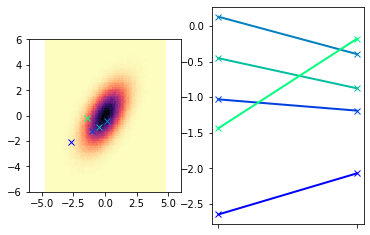

In [3]:
rng = np.random.default_rng() # sets up a random number generator
ndim= 2
nsamples = 5

# define the distribution and draw samples
mean=np.zeros(ndim) # zero mean
cov =np.array([[1,0.8],[0.8,2]]) # some covariance matrix with correlation present
samples = rng.multivariate_normal(mean,cov,nsamples)

# for reference, we will generate a ton of samples to visualize the "true" distribution
x1t,x2t = rng.multivariate_normal(mean,cov,1000000).T
fig,ax = plt.subplots(1,2)
ax[0].hist2d(x1t,x2t,bins=(100,100),cmap=plt.cm.magma_r)

# and we will overlay our samples on top of this
mycmap = plt.cm.get_cmap('winter',nsamples)
myColors = [mycmap(i/(nsamples-1.)) for i in range(nsamples)]
for i,sample in enumerate(samples):
  ax[0].plot(sample[0],sample[1],linestyle = 'none', marker = 'x', color = myColors[i],linewidth=5 )
ax[0].axis('square')
ax[0].set_xlim([-6,6])
ax[0].set_ylim([-6,6])

# Now we will also represent these same draws by plotting them 
# as lines connecting the two Gaussian vectors
xrvs = [dim/(ndim-1.) for dim in range(ndim)]
for i,sample in enumerate(samples):
    ax[1].plot(xrvs,sample,linestyle='-',marker = 'x',color=myColors[i],linewidth=2)
ax[1].xaxis.set_ticks(xrvs)
ax[1].xaxis.set_ticklabels([])    
plt.show()

Now, we let's consider more complex situation: a *30-dimensional* Gaussian. Of course, we will not show the underlying distribution but use the "line view" to illustrate the samples. We will choose to represent the covariance as 
$$k(x_i,x_j) = \exp \left[-\frac{(x_i-x_j)^2}{2} \right]$$. How does this compare to the covariance from the previous cell?

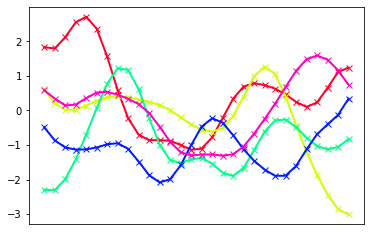

In [4]:
def covkernel(xi,xj,l=1.0):
    dij= cdist(xi,xj,metric='euclidean') # returns matrix of pairwise distances
    return np.exp(-0.5*dij**2/l**2)

ndim     = 30
nsamples = 5
length_scale = 0.1
xrvs     = np.linspace(0,1,ndim)[:,np.newaxis]
mycmap = plt.cm.get_cmap('gist_rainbow',nsamples)
myColors = [mycmap(i/(nsamples-1.)) for i in range(nsamples)]

# define the distribution and draw samples
mean=np.zeros(ndim) # zero mean
cov = covkernel(xrvs,xrvs,l=length_scale) # some covariance matrix with correlation present
samples = rng.multivariate_normal(mean,cov,nsamples)

# Represent the draws by plotting them 
# as lines connecting the Gaussian vectors
fig,axs = plt.subplots(1)
for i,sample in enumerate(samples):
    axs.plot(xrvs,sample,linestyle='-',marker = 'x',color=myColors[i],linewidth=2)
axs.xaxis.set_ticks(list(xrvs))
axs.axes.get_xaxis().set_visible(False)

plt.show()

## Example GPR with Van der Waals EOS
Now, let's see if we can generate a few "observations," and then sample the posterior. Let's assume our true function is something we know, like the Van der Waals equation of state:

$$P_r = \frac{8}{3}\frac{T_r}{V_r - \frac{1}{3}}-\frac{3}{V_r^2}$$

To keep this problem in a physically reasonable range, we will suppose $T_r = 0.85$ and examine $V_r$ over the range of 0.5 to 4. In the following, we can include fewer or more observations to illustrate how our uncertainty changes.

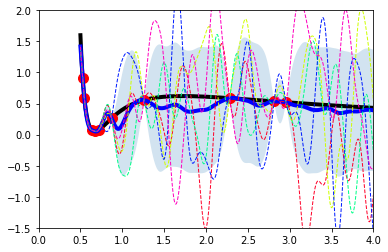

In [6]:
def vdw_P(Tr,Vr):
    term1 = 8.*Tr/(3*Vr-1)
    term2 = 3.0/(Vr*Vr)
    return term1 - term2

def make_plot(Vs,Ps,x,y):
    fig,axs = plt.subplots(1)
    axs.plot(Vs,Ps,linestyle='-',color='k',linewidth=4)
    axs.plot(x[:,0],y[:,0],linestyle='none',marker = 'o',color='r',markersize=10)
    axs.set_xlim([0,4])
    axs.set_ylim([-1.5,2])
    return fig,axs

def make_plot_posterior(axs,fmean,fp,fm):
    axs.fill_between(xs[:,0],fm,fp,alpha = 0.2)
    axs.plot(xs,fmean,linestyle='-',color='b',linewidth=4)
    return 

# look at a reasonable range of parameters
Tr = 0.85
Vmin,Vmax = 0.5,4
Vs = np.linspace(Vmin,Vmax,1000)
Ps = vdw_P(Tr,Vs)

# generate random observations (over slightly smaller interval)
nobs = 10
x    = Vmin + (Vmax-1-Vmin)*rng.random(nobs) # random samples for V
x    = x[:,np.newaxis]
y    = vdw_P(Tr,x)
yavg = np.mean(y)
fig,axs = make_plot(Vs,Ps,x,y)

# now generate our test points (denoted *)
xs = Vs[:,np.newaxis]

# we need to get all of the relevant covariant matrices
length  = 0.1
kxsx    = covkernel(xs,x,l=length)
kxx     = covkernel(x,x,l=length)
invkxx  = np.linalg.inv(kxx)
kxsxs   = covkernel(xs,xs,l=length)
kxxs    = covkernel(x,xs,l=length)

# now we can sample the posterior with the following
# mean and covariance functions. We will generate a number of samples
# and then show a few for representation sake
# Note: as a "prior" to formulate the mean over our functions, we will use an ideal gas
# the observe mean
muf   = yavg
meanf = muf+kxsx@invkxx@(y-yavg) # <-- differs from common eqns that assume mean = 0
covf  = kxsxs - kxsx@invkxx@kxxs
nsamples = 500
samples  = rng.multivariate_normal(meanf[:,0],covf,nsamples)
sample_mean = np.mean(samples,axis=0)
sample_std  = np.std(samples,axis=0)
mean_plus   = sample_mean + 1*sample_std
mean_minus  = sample_mean - 1*sample_std
make_plot_posterior(axs,sample_mean,mean_minus,mean_plus)

for i,sample in enumerate(samples[:5]):
    axs.plot(xs,sample,linestyle='--',color=myColors[i],linewidth=1)
    
plt.show()

The above presumes noise-free observations and also uses a naive formulation scheme with direct sampling to obtain our results. The posterior mean and variance can actually be obtained directly as we will show next. First run the cell below leaving `sigma_n` to be 0 (i.e., noise-free) and compare the results with the previous cell. Then, run again by changing the value of the noise to get a feel for how noisy observations impact the GP.  

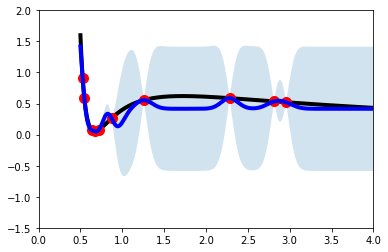

In [8]:
# new targets with noise:
sigma_n = 0.0

# add noise to previous observations
y    = vdw_P(Tr,x) + rng.normal(loc=0,scale=sigma_n,size=nobs)[:,np.newaxis]
yavg = np.mean(y)

# conventional algorithm
length  = 0.1
kxsx    = covkernel(xs,x,l=length)
kxx     = covkernel(x,x,l=length)
kxsxs   = covkernel(xs,xs,l=length)
kxxs    = covkernel(x,xs,l=length)

#meanf = muf+kxsx@invkxx@(y-yavg) 
# 1. Cholesky decomposition of K(x,x)
L = np.linalg.cholesky(kxx)

# 2. Obtain alpha = L.T|(L|y) = L.T/b 
b     = np.linalg.lstsq(L,y[:,0]-yavg,rcond=None)[0]
alpha = np.linalg.lstsq(L.T,b,rcond=None)[0]

# 3. Obtain the posterior mean function
fmean = yavg + kxxs.T@alpha

# 4. obtain posterior variance function
v = np.linalg.lstsq(L,kxxs,rcond=None)[0]
fvar = np.diag(kxsxs - v.T@v)
fstd = np.sqrt(fvar)
mean_plus   = fmean + 1*fstd
mean_minus  = fmean - 1*fstd

#plotting
fig,axs = make_plot(Vs,Ps,x,y)
make_plot_posterior(axs,fmean,mean_minus,mean_plus)
plt.show()

## scikit-learn GPR Implementation
Now, we will simply repeat the exercise but using built-in functions from `scikit-learn` to do the GPR. There are many other python packages that support GPR. `scikit-learn` provides a good and simple GPR implementation, but if one desires more advanced capabilities, customizability, and performance -- another package may be preferred.

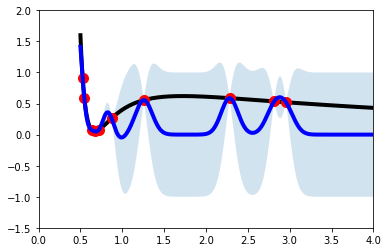

In [15]:
the_kernel = RBF(length_scale=0.1,length_scale_bounds="fixed")
the_model  = GaussianProcessRegressor(kernel=the_kernel)
the_model.fit(x,y)
fmean,fstd = the_model.predict(xs,return_std=True)
mean_plus   = fmean[:,0] + 1*fstd
mean_minus  = fmean[:,0] - 1*fstd

# plotting
fig,axs = make_plot(Vs,Ps,x,y)
make_plot_posterior(axs,fmean,mean_minus,mean_plus)
plt.show()

Notice that using scikit-learn it presumes that the mean should be zero! This highlights a need that we should probably normalized our data. Recent version of scikit learn allow you to specify whether the data should be normalized during GPR when you build the Regressor. My opinion is that you should handle this yourself so you have a firm idea as to what is happening with your data. We will demonstrate this by using a little bit of preprocessing... 

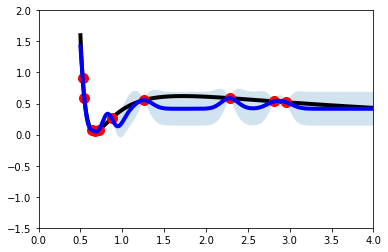

In [14]:
scaler = preprocessing.StandardScaler().fit(y)
yscaled= scaler.transform(y) 
# to keep the comparison similar to before, we will 
# also account for scaling to unit standard deviation
# newer versions of scikit-learn can use the option with_std = False
# but mine does not have this, and I do not want to update it right now

# fit to transformed y data, then inverse_transform
the_kernel = RBF(length_scale=0.1,length_scale_bounds="fixed")
the_model  = GaussianProcessRegressor(kernel=the_kernel,normalize_y=False)
the_model.fit(x,yscaled)
fmeanscaled,fstdscaled = the_model.predict(xs,return_std=True)
fmean       = scaler.inverse_transform(fmeanscaled)
mean_plus   = scaler.inverse_transform(fmeanscaled+ fstdscaled[:,None])
mean_minus  = scaler.inverse_transform(fmeanscaled- fstdscaled[:,None])

#plotting
fig,axs = make_plot(Vs,Ps,x,y)
make_plot_posterior(axs,fmean[:,0],mean_minus[:,0],mean_plus[:,0])
plt.show()

That looks better! In the cell above, we show when building the `GaussianProcessRegressor` how you can specify whether your label should be normalized with the `normalize_y` option. Go ahead and add this flag with `True` to the cell where we unintentionally assumed a zero-mean prior and see how this now compares with the result just generated.

# Team Activity: Active Learning Challenge

In this activity, we will deploy *active learning* to identify a molecule that fits some specific target physical property. In specific, we will be working from a pool of molecules that can be found in the ClinTox dataset, which includes a combination of drugs that have failed clinical trials for toxicity reasons as well as drugs that are assocated with successful trials. It is a commonly used dataset for binary classification, but here, we will simply use it as a source for interesting molecular structures. Here is a summary of the challenge:

* Our "design" task will be to find a molecule that has a specific *boiling temperature*, $T_b$.
* Predictions from `leruli` will represent the *ground truth* data on $T_b$ for any molecule
* We will start with approximately 50 labeled chemical structures
* Gaussian process regression (GPR) will be used as a surrogate model for predicting $T_b$ as a function of molecule chemistry
* The molecule chemistry will be represented via chemical descriptors computed by `mordred`; these will be used as inputs for the GPR 

## Pre-processing
For the workshop, we have done a number of curation and pre-processing steps ahead of time. You can view code relevant to these steps below, but you need not run it. The most time-consuming portion is just running `mordred` to compute all the chemical descriptors for everything within the dataset. At a "meta" level, we also needed to exclude a number of chemical structures that were not processible by `leruli`. 

Relevant files generated pre-workshop:
*
*
*

[20:24:21] Explicit valence for atom # 0 N, 5, is greater than permitted
[20:24:21] Can't kekulize mol.  Unkekulized atoms: 9
[20:24:21] Explicit valence for atom # 10 N, 4, is greater than permitted
[20:24:21] Explicit valence for atom # 10 N, 4, is greater than permitted
[20:24:21] Can't kekulize mol.  Unkekulized atoms: 4
[20:24:21] Can't kekulize mol.  Unkekulized atoms: 4


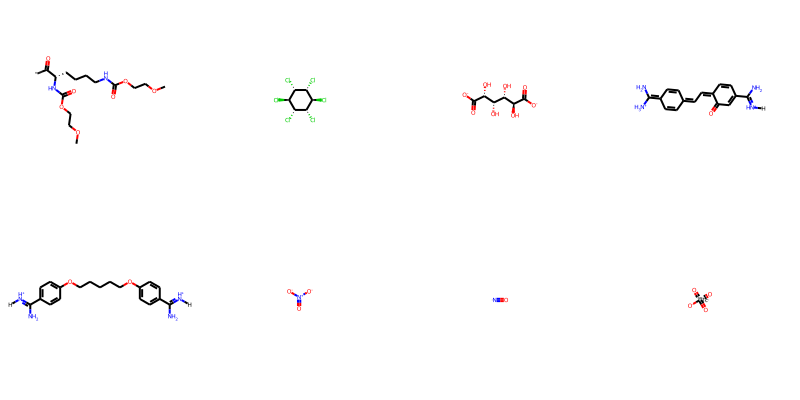

We initially extract 1478 convertible molecular structures from this dataset.


In [89]:
# download ClinTox from dmol-book
# remove any structures that cannot be converted
toxdata = pd.read_csv(
    "https://github.com/whitead/dmol-book/raw/master/data/clintox.csv.gz"
)
toxdata.head()
PT.AddMoleculeColumnToFrame(toxdata,smilesCol='smiles',includeFingerprints=False)
toxdata= toxdata[~toxdata['ROMol'].isnull()] # removes any structures that failed to convert
N = len(toxdata)
display(PT.FrameToGridImage(toxdata.head(8), molsPerRow=4))
toxdata = toxdata.reset_index()
print("We initially extract {} convertible molecular structures from this dataset.".format(N))

In [15]:
calculator = Calculator(descriptors,ignore_3D=True)
wdesc      = calculator.pandas(toxdata['ROMol'])
# the below will prune away any descriptors that did not have valid calculations
missing = []
for column in wdesc.columns:
    if (wdesc[column].apply(lambda x: type(x) == Missing)).any():
        missing.append(column)
wdesc = wdesc.drop(missing,axis=1)
wdesc.head()

  2%|▏         | 24/1478 [00:16<28:23,  1.17s/it]

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


  8%|▊         | 120/1478 [00:57<47:51,  2.11s/it]

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 1478/1478 [17:12<00:00,  1.43it/s]


After computing descriptors from Mordred and immediately discarding any descriptors that gave *any* molecule trouble. This takes us from ~1500 descriptors down to around 600. We then further reduce the dimensionality of our prospective inputs by applying versions of a low-variance and high-correlation filters. This leaves us with about 250 descriptors for each molecule, which we write to `filtered.csv` 

In [66]:
wdesc2 = wdesc.copy(deep=True)

# low variance filter
low_var = []
for column in wdesc2.columns:
  var = wdesc2[column].var()
  if (var < 1e-5):
    low_var.append(column)
  else:
    mu = wdesc2[column].mean()
    wdesc2[column] = (wdesc2[column]-mu)/var 
wdesc2 = wdesc2.drop(low_var,axis=1)

# greedy high correlation filter
corr = wdesc2.corr().to_numpy()
np.fill_diagonal(corr,0.0)
X = wdesc2.to_numpy()
import random
random.seed(0)
cid = list(range(X.shape[1]))
random.shuffle(cid)
too_corr = []
r_max = 0.9
keep = []
while cid:
  i  = cid.pop(0)
  keep.append(i)
  corr_i     = corr[i,:]
  too_corr_i = np.argwhere(np.abs(corr_i) >= 0.9)
  for j in too_corr_i:
    try:
      too_corr.append(cid.pop(cid.index(j)))
    except ValueError:
      pass

wdesc2 = wdesc2.drop(wdesc2.columns[too_corr],axis=1)
wdesc2.to_csv("filtered.csv")

(1478, 599)
(1478, 485)


## Using leruli
In active learning, we are typically making measurements iteratively. To mimic taking measurements, we will make calls to `leruli` to grab values of $$T_b$$, which we will treat as the "ground truth" label for any given molecule. Examine and run the cell below to understand how to query `leruli` for a physical property using a SMILES representation of the molecular graph. We will use the boiling point as the property; note that the units returned from `leruli` are in Celsius.

We now have 1376 molecules
Here are some boiling points for some molecules:
For molecule C(=O)[C@H](CCCCNC(=O)OCCOC)NC(=O)OCCOC
  Tb = 537.0 K

For molecule [C@@H]1([C@@H]([C@@H]([C@H]([C@@H]([C@@H]1Cl)Cl)Cl)Cl)Cl)Cl
  Tb = 509.5 K

For molecule [C@H]([C@@H]([C@@H](C(=O)[O-])O)O)([C@H](C(=O)[O-])O)O
  Tb = 587.2 K

For molecule [H]/[NH+]=C(/C1=CC(=O)/C(=C\C=c2ccc(=C([NH3+])N)cc2)/C=C1)\N
  Tb = 631.7 K

For molecule [H]/[NH+]=C(\N)/c1ccc(cc1)OCCCCCOc2ccc(cc2)/C(=[NH+]/[H])/N
  Tb = 628.8 K

For molecule [N+](=O)([O-])[O-]
  Tb = 351.3 K

For molecule [N]=O
  Tb = 298.2 K

For molecule [O-]P(=O)([O-])F
  Tb = 352.1 K



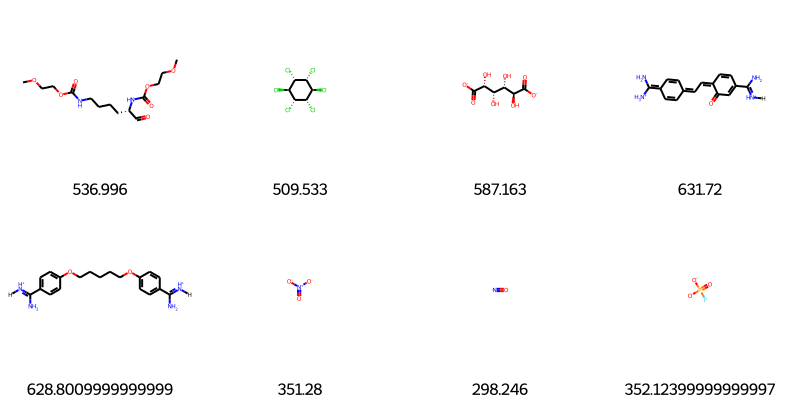

In [91]:
import leruli

# load in csv with smiles column
path2git=\
"https://raw.githubusercontent.com/webbtheosim/ml-workshop-acsmarm2022/main/site/source/20220603-applied/"
curtox = pd.read_csv(
    path2git + "curated_clintox_smiles.csv"
)[['smiles']]
N   = curtox.shape[0]
print("We now have {} molecules".format(N))

# use leruli to "measure" boiling points for a subset
m = 8
subset = curtox.iloc[0:m,:].copy()
PT.AddMoleculeColumnToFrame(subset,smilesCol='smiles',includeFingerprints=False)
Tbs = [-1000 for i in range(m)]
print("Here are some boiling points for some molecules:")
for i,smi in enumerate(subset['smiles'][:]):
    Tbs[i] = leruli.graph_to_boiling_point(smi)['bp']+273.15
    print("For molecule {}\n  Tb = {:>5.1f} K\n".format(smi,Tbs[i]))

subset['Tb'] = Tbs
display(PT.FrameToGridImage(subset, legendsCol='Tb', molsPerRow=4))

## GPR Kernel

Because the mathematics underlying GPR are pretty linear (in a literal sense), perhaps the most critical decision that one makes is the choice of kernel, which describes the covariance amongst random variables. The kernel and its parameters are the *hyperparameters* for GPR.

In the active learning paradigm, we will be building potentially many models, so we will write a function that we can use to re-initialize a fresh kernel each time. Familiarize yourself with and run the cell below to implement a kernel of the form

$$k(x_i,x_j) = C \exp \left[-\frac{d(x_i,x_j)^2}{2L^2} \right] + N$$

Otherwise, examine the doc pages to implement a different kind of kernel. 

In [92]:
from scipy.spatial.distance     import pdist,cdist
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
from scipy.optimize             import minimize, minimize_scalar
from sklearn.gaussian_process   import GaussianProcessRegressor
from scipy.special import erf
from sklearn.model_selection  import train_test_split, KFold
from sklearn.metrics     import r2_score, mean_squared_error,mean_absolute_error
import seaborn as sns
import warnings
from rdkit import Chem
warnings.filterwarnings("ignore")
def build_kernel(params):
  [C,N,L] = [params[key] for key in ['const','noise','length']]
  the_kernel =\
     ConstantKernel(constant_value=C)\
         * RBF(length_scale=L) \
         + WhiteKernel(noise_level=N,noise_level_bounds=(1e-10,1))
  return the_kernel

##  Acquisition functions
In active learning, we define an acquisition function that enables us to identify the next "best" measurement; the notion of best is obviously subject to change based on the choice of acquisition function. In the cell below, we are going to define to write code to compute two different acquisition functions that we discussed, the **upper confidence bound** and **expected improvement** acquisition functions.


In [93]:
#==================================================================
#  AUX: eval_UCB
#==================================================================
# T = target function value
# M = mean of model evaluated at x
# S = standard deviation of model evaluated at X
# E = weighting parameter
def eval_UCB(T,M,S,E=0.5):
  UCB = M + S*E
  return UCB

#==================================================================
#  AUX: eval_EI
#==================================================================
# T = target function value
# M = mean of model evaluated at x
# S = standard deviation of model evaluated at X
# E = Xi parameter
# cumNrmDist is the cumulative unit normal distribution
# NrmDist is the standard normal probability distribution
def eval_EI(T,M,S,E=0.01):
  dmuT      = M - T - E
  dmuTbyS   = dmuT / S
  cumNrmDist= 0.5*(1. + erf(dmuTbyS/np.sqrt(2.)))
  NrmDist   = np.exp(-0.5*dmuTbyS**2.0)/np.sqrt(2*np.pi)
  EI        = dmuT * cumNrmDist + S * NrmDist
  return EI

## Data Preparation and Target Definition
Examine, modify, and run the cells below to prepare for our challenge! Our goal will be to find a molecule that has a boiling temperature close to 250 K. 

Critically, we are loading a .csv that has already measured ~50 boiling temperatures for some randomly selected molecules in the ClinTox dataset. In the .csv, points that are labeled with "-1000" are currently unknown. 

Write some code to extract *only the measured data points* and examine how they are distributed. Are there any data points that are currently close to our target?

In [95]:
# define our target
target = 235  # desired boiling temperature in K
Xi     = 0.5  # weighting parameter, if desired, for use in acquisition functions

# load data
y  = pd.read_csv(path2git + "curated_clintox_Tb_0.csv").to_numpy()[:,-1][:,None] # array of Tb
X  = pd.read_csv(path2git + "curated_clintox_features.csv").to_numpy()[:,:]      # array of descriptors
yinit = y.deepcopy()
Xinit = X.deepcopy()

# get scaler for features, X
# because our pool of molecules is known a priori and unchanging
# we will perform our transformation of input features in consideration
# of the whole space -- usually you would just use the training data,
# but I do not really see a problem with using all the structures here
Xscaler    = preprocessing.StandardScaler().fit(X)
X_sc       = Xscaler.transform(X)

# find indices with unmeasured boiling points
nodata = np.squeeze(y)<0.0

# plot distribution of measured boiling temperatures
sns.distplot(y[~nodata,:])
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'deepcopy'

## Active learning loop
In the cell below, we have set up a framework for conducting the active learning exercise. 

Examine and complete the cell below. While testing you may want to replace the `while` loop with a `for` loop that can only execute one or two times. 

Are you able to find a suitable target? What fraction of the pool is explored to find this target?

There are currently 50 labeled samples
Current closest value to target is 331.2
For molecule C(C(CS)S)O
  Tb = 443.9 K

There are currently 51 labeled samples
Current closest value to target is 331.2
For molecule CS(=O)C
  Tb = 462.2 K

There are currently 52 labeled samples
Current closest value to target is 331.2
For molecule C([C@@H](C(=O)[O-])[NH3+])S
  Tb = 407.4 K

There are currently 53 labeled samples
Current closest value to target is 331.2
For molecule [N]=O
  Tb = 298.2 K

There are currently 54 labeled samples
Current closest value to target is 298.2
For molecule [Se]
  Tb = 321.1 K

There are currently 55 labeled samples
Current closest value to target is 298.2
For molecule N(=O)[O-]
  Tb = 311.2 K

There are currently 56 labeled samples
Current closest value to target is 298.2
For molecule Cl[Cu]Cl
  Tb = 392.0 K

There are currently 57 labeled samples
Current closest value to target is 298.2
For molecule C#N
  Tb = 298.8 K

There are currently 58 labeled samples
Current 

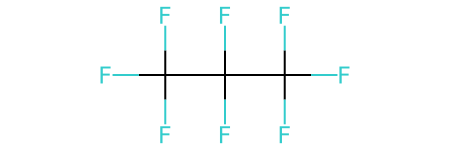

In [85]:
# best to re-load data in this cell
y  = pd.read_csv(path2git + "curated_clintox_Tb_0.csv").to_numpy()[:,-1][:,None] # array of Tb
X  = pd.read_csv(path2git + "curated_clintox_features.csv").to_numpy()[:,:]      # array of descriptors

# find indices with unmeasured boiling points
nodata = np.squeeze(y)<0.0

niter = 0
while nodata.any():
#for jj in range(1):

    # extract the training data from 'X' and 'y' above
    X0     = X[~nodata,:].copy()
    y0     = y[~nodata,:].copy()
    ibest  = np.argmin((y0-target)**2)
    ybest  = y0[ibest][0]
    print("There are currently {} labeled samples".format(len(y0)))
    print("Current closest value to target is {:>5.1f}".format(ybest))
    
    # increment counter and check convergence
    niter += 1
    conv   = 100*np.abs(ybest-target)/target < 1. # setup something to determine convergence
    if (conv):
        print("\n\nWe have found a molecule!")
        break
    elif niter >= 50:
        print("We have not found a molecule!")
        print("Consider a different target, acquisition function, or loosening convergence criterion")
        break    
    
    # perform data transformation and feature scaling on labels
    # you should only scale the labels with the values in y0
    X0_sc    = Xscaler.transform(X0)     # the Xscaler was defined earlier
    yscaler  = preprocessing.StandardScaler().fit(y0)
    y0_sc    = yscaler.transform(y0)
    T_sc     = yscaler.transform([[target]])[0] # this is the transformed value of our target
    
    # build a GPR surrogate model
    the_kernel = build_kernel({'const': 1.0, 'length' : 20, 'noise': .05}) 
    the_model  = GaussianProcessRegressor(kernel=the_kernel,n_restarts_optimizer=10)
    
    # train the model with our known data
    the_model.fit(X0_sc,y0_sc)

    # make predictions (we can just do over the whole dataset for simplicity)
    yhat_sc_mean,yhat_sc_std = the_model.predict(Xscaler.transform(X),return_std=True)
    yhat_mean   = yscaler.inverse_transform(yhat_sc_mean[:,0])
    mean_plus   = yscaler.inverse_transform(yhat_sc_mean[:,0]+ yhat_sc_std)
    mean_minus  = yscaler.inverse_transform(yhat_sc_mean[:,0]- yhat_sc_std)

    # compute acquisition function for all unlabeled data points
    acq  = -1.0*np.ones(len(y))
    T    = 1./(yscaler.transform([[ybest]])[0] - T_sc)**2
    for i,flag in enumerate(nodata):
        if flag:
            M  = 1./(yhat_sc_mean[i]-T_sc)**2
            S  = 2*yhat_sc_std[i]/(yhat_sc_mean[i]-T_sc)**3
            acq[i] = eval_EI(T,M,S,0.01)
            #acq[i] = eval_UCB(T,M,S,1.0)
            
    # select new point for measurement/query
    inew = np.argmax(acq)
    nodata[inew] = False
    
    # get value with leruli
    smi = curtox.loc[inew,'smiles']
    y[inew] = leruli.graph_to_boiling_point(smi)['bp']+273.15
    print("For molecule {}\n  Tb = {:>5.1f} K\n".format(smi,y[inew][0]))
    
ibest    = np.argmin((y-ybest)**2)
the_best = Chem.MolFromSmiles(curtox.loc[ibest,'smiles'])
print("The boiling point of the best found match is {:>5.1f}".format(y[ibest][0]))
print("Here we have it:")
the_best

## Performance of the GPR model during active learning

One thing that may be sometimes surprising is that the accuracy of models during active learning campaigns may actually be somewhat low, and yet our targets are still achieved. In such scenarios, we consider the value of the surrogate model to be predictive *enough* to point us in the right direction. Another thing to consider during active learning is that our training set is *heavily* biased. Should we even expect it to generalize well? When might we?

If you have extra time in the workshop (or after), you might consider actually assessing how well GPR does in predicting $T_b$ for dataset. You can do this with the small amount of data given or perhaps acquire more data using `leruli`. For reference, we have trained models and assessed their performance using 5-fold cross-validation using the same kernel choice as earlier. The output is shown below for reference and should give you some sense of the type of accuracy that can be achieved. 

[0.85011669 0.88614936 0.80833342 0.84293131 0.80548622]


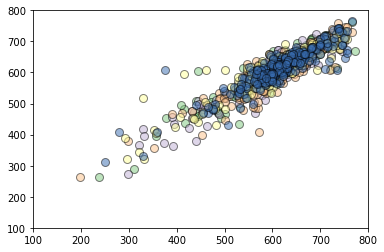

In [63]:
from scipy.spatial.distance     import pdist,cdist,squareform
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern,ConstantKernel
from scipy.optimize             import minimize, minimize_scalar
from sklearn.gaussian_process   import GaussianProcessRegressor
from scipy.special import erf
from sklearn.model_selection  import train_test_split, KFold
from sklearn.metrics     import r2_score, mean_squared_error,mean_absolute_error

# We will estimate the model accuracy using cross-validation
k     = 5
kf    = KFold(n_splits=k,shuffle=True,random_state=1)
r2s   = np.zeros([k])
mses  = np.zeros([k])
maes  = np.zeros([k])

fig,axs = plt.subplots()
colors =  plt.cm.Accent([i for i in range(k)])
for i,(iTrain,iTest) in enumerate(kf.split(y)):
    Xi_tr = X[iTrain]
    Xi_te = X[iTest]
    yi_tr = y[iTrain]
    yi_te = y[iTest]
    the_kernel = build_kernel({'const': 1.0, 'length' : 1e-3, 'noise': .05}) #,length_scale_bounds="fixed")
    the_model  = GaussianProcessRegressor(kernel=the_kernel)
    Xscaler    = preprocessing.StandardScaler().fit(Xi_tr)
    yscaler    = preprocessing.StandardScaler().fit(yi_tr)
    X_sc       = Xscaler.transform(Xi_tr)
    y_sc       = yscaler.transform(yi_tr)
    the_model.fit(X_sc,y_sc)
    yhat_sc_mean,yhat_sc_std = the_model.predict(Xscaler.transform(Xi_te),return_std=True)
    
    
    yhat_mean   = yscaler.inverse_transform(yhat_sc_mean[:,0])
    mean_plus   = yscaler.inverse_transform(yhat_sc_mean[:,0]+ yhat_sc_std)
    mean_minus  = yscaler.inverse_transform(yhat_sc_mean[:,0]- yhat_sc_std)
    (r2s[i],mses[i],maes[i]) = \
    (r2_score(yi_te,yhat_mean),mean_squared_error(yi_te,yhat_mean),mean_absolute_error(yi_te,yhat_mean))
    plt.plot(yi_te,yhat_mean,marker='o',linestyle="",markersize=8,color=colors[i],markeredgecolor='k',alpha=0.5)
plt.xlim([100,800])
plt.ylim([100,800])
print(r2s)
plt.show()